In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from deap import base, creator, tools, algorithms
import numpy as np
import random
from scipy.optimize import differential_evolution
from pyswarm import pso

In [2]:
df=pd.read_csv('fndds_ingredient_nutrient_value.csv')

In [3]:
df.tail()

,ingredient code,Ingredient description,Nutrient code,Nutrient value,Nutrient value source,FDC ID,Derivation code,SR AddMod year,Foundation year acquired,Start date,End date
273905,999431,Folic acid as ingredient,629,0.0,Nutrient as ingredient,NaN,NaN,NaN,0,2019-01-0,2020-12-3
273906,999431,Folic acid as ingredient,630,0.0,Nutrient as ingredient,NaN,NaN,NaN,0,2019-01-0,2020-12-3
273907,999431,Folic acid as ingredient,631,0.0,Nutrient as ingredient,NaN,NaN,NaN,0,2019-01-0,2020-12-3
273908,999431,Folic acid as ingredient,645,0.0,Nutrient as ingredient,NaN,NaN,NaN,0,2019-01-0,2020-12-3
273909,999431,Folic acid as ingredient,646,0.0,Nutrient as ingredient,NaN,NaN,NaN,0,2019-01-0,2020-12-3


In [4]:
df.shape

(273910, 11)

In [5]:
df.describe()

,ingredient code,Nutrient code,Nutrient value,FDC ID,SR AddMod year,Foundation year acquired
count,273910.000000,273910.000000,2.739100e+05,2.693810e+05,267162.000000,273910.000000
mean,20914.135501,438.476923,5.686375e+01,1.753678e+05,1981.692232,29.749286
std,71862.781153,150.910856,4.660525e+03,9.731496e+04,210.448612,242.901329
min,1001.000000,203.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,8019.000000,309.000000,0.000000e+00,1.692760e+05,2001.000000,0.000000
50%,14093.000000,415.000000,9.800000e-02,1.713720e+05,2006.000000,0.000000
75%,19280.000000,611.000000,5.200000e+00,1.733320e+05,2011.000000,0.000000
max,999431.000000,646.000000,1.700000e+06,2.003601e+06,2018.000000,2021.000000


In [6]:
df.isnull().sum()

ingredient code                 0
Ingredient description          0
Nutrient code                   0
Nutrient value                  0
Nutrient value source           0
FDC ID                       4529
Derivation code             76626
SR AddMod year               6748
Foundation year acquired        0
Start date                      0
End date                        0
dtype: int64

In [7]:
df = df.drop_duplicates()

In [8]:
# Date conversion to standard form
df['Start date'] = pd.to_datetime(df['Start date'], errors='coerce')
df['End date'] = pd.to_datetime(df['End date'], errors='coerce')

# Standardize text formats
df['Ingredient description'] = df['Ingredient description'].str.lower().str.strip()

C:\Users\Naresh Kumar S\AppData\Local\Temp\ipykernel_17104\425725304.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Start date'] = pd.to_datetime(df['Start date'], errors='coerce')


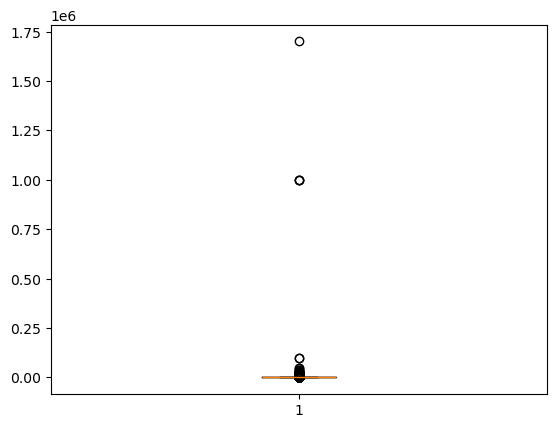

In [9]:
# Boxplot for outlier detection
plt.boxplot(df['Nutrient value'])
plt.show()
from scipy import stats
df['z_score'] = stats.zscore(df['Nutrient value'])
outliers = df[df['z_score'].abs() > 3]
#print(outliers)


In [10]:
cap = df['Nutrient value'].quantile(0.95)
df['Nutrient value'] = df['Nutrient value'].apply(lambda x: cap if x > cap else x)


In [11]:
df = df[(df['z_score'].abs() <= 3)]

In [12]:
# Normalize the data
scaler = MinMaxScaler()
df['Nutrient value'] = scaler.fit_transform(df[['Nutrient value']])

# Standardize the data
scaler = StandardScaler()
df['Nutrient value'] = scaler.fit_transform(df[['Nutrient value']])


In [13]:
# Create a new feature that sums up all nutrient values for a given ingredient
df['Total Nutrient Value'] = df.groupby('ingredient code')['Nutrient value'].transform('sum')


In [14]:
df.describe()

,ingredient code,Nutrient code,Nutrient value,FDC ID,SR AddMod year,Foundation year acquired,Start date,End date,z_score,Total Nutrient Value
count,273873.000000,273873.000000,2.738730e+05,2.693510e+05,267133.000000,273873.000000,0,273873,273873.000000,273873.000000
mean,20890.335513,438.490863,2.739712e-17,1.753655e+05,1981.697334,29.738569,NaT,2019-10-25 10:54:52.372742144,-0.004425,-0.395975
min,1001.000000,203.000000,-4.128585e-01,0.000000e+00,0.000000,0.000000,NaT,2018-12-03 00:00:00,-0.012201,-52.823325
25%,8019.000000,309.000000,-4.128585e-01,1.692760e+05,2001.000000,0.000000,NaT,2018-12-03 00:00:00,-0.012201,-12.785349
50%,14093.000000,415.000000,-4.101228e-01,1.713720e+05,2006.000000,0.000000,NaT,2018-12-03 00:00:00,-0.012180,-0.494173
75%,19280.000000,611.000000,-2.662006e-01,1.733320e+05,2011.000000,0.000000,NaT,2020-12-03 00:00:00,-0.011085,12.399371
max,999431.000000,646.000000,3.563828e+00,2.003601e+06,2018.000000,2021.000000,NaT,2020-12-03 00:00:00,2.969228,84.276197
std,71697.071287,150.915728,1.000002e+00,9.731374e+04,210.424975,242.858076,NaN,NaN,0.056965,21.205969


In [15]:
df.head()

,ingredient code,Ingredient description,Nutrient code,Nutrient value,Nutrient value source,FDC ID,Derivation code,SR AddMod year,Foundation year acquired,Start date,End date,z_score,Total Nutrient Value
0,1001,"butter, salted",203,-0.388886,SR Legacy,173410.0,NaN,1976.0,0,NaT,2018-12-03,-0.012019,14.012383
1,1001,"butter, salted",204,1.874723,SR Legacy,173410.0,NaN,1976.0,0,NaT,2018-12-03,0.005202,14.012383
2,1001,"butter, salted",205,-0.411166,SR Legacy,173410.0,NC,1976.0,0,NaT,2018-12-03,-0.012188,14.012383
3,1001,"butter, salted",208,3.563828,SR Legacy,173410.0,NC,2010.0,0,NaT,2018-12-03,0.141644,14.012383
4,1001,"butter, salted",221,-0.412858,SR Legacy,173410.0,NaN,1985.0,0,NaT,2018-12-03,-0.012201,14.012383


In [16]:
df.columns

Index(['ingredient code', 'Ingredient description', 'Nutrient code',
       'Nutrient value', 'Nutrient value source', 'FDC ID', 'Derivation code',
       'SR AddMod year', 'Foundation year acquired', 'Start date', 'End date',
       'z_score', 'Total Nutrient Value'],
      dtype='object')

In [17]:
ingredient_codes = df['ingredient code'].unique()
nutrient_values = df.groupby('ingredient code')['Total Nutrient Value'].mean().values
def evaluate(individual):
    quantities = np.array(individual)
    predicted_value = np.sum(quantities * nutrient_values)
    error = abs(predicted_value - target_value)
    return (error,)

# Define the target nutrient value
target_value = 15.0 

# Define Genetic Algorithm problem
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.uniform, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=len(ingredient_codes))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)


# Create population and run GA
population = toolbox.population(n=100)
algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, verbose=True)

gen	nevals
0  	100   
1  	60    
2  	57    
3  	45    
4  	71    
5  	56    
6  	56    
7  	53    
8  	63    
9  	62    
10 	53    


([[0.15732803910971027,
   0.6208368704265488,
   0.5456884717939466,
   0.2433775961916927,
   0.7814773280193201,
   0.6120184384881348,
   0.9052355257206552,
   0.4446911748244386,
   0.06955058975614116,
   0.7293170039025488,
   0.06928455345606806,
   0.7656834099954095,
   0.3993293552004555,
   0.9679120787260729,
   0.8689221818865973,
   0.5326819630740237,
   0.6065316831743809,
   -0.13476877190856612,
   0.5039535293089322,
   0.7348716723831457,
   0.7470639494290979,
   1.026104644589923,
   0.15903013244880027,
   0.4218305212889638,
   -0.2671051869138354,
   0.5253997625895823,
   0.8572761820546719,
   0.23648408421308442,
   0.6110205487481716,
   -0.12180417627637413,
   0.13799016555225077,
   0.8363934301522515,
   0.5704875536437025,
   0.5292134104185867,
   0.3573487756537932,
   1.0014364146782513,
   0.08668142272528942,
   0.7434591881763102,
   0.6593411644240067,
   0.7152295851618983,
   0.38569651977683533,
   0.7672332065390666,
   0.49256473694044817

gen	nevals	min     	avg    
0  	0     	0.648979	58.5067
1  	63    	0.157724	48.9656
2  	67    	0.157724	49.6901
3  	74    	0.157724	51.5338
4  	55    	0.157724	38.18  
5  	71    	0.157724	44.7478
6  	57    	0.157724	47.541 
7  	56    	0.157724	37.7046
8  	62    	0.157724	39.3496
9  	63    	0.157724	37.3316
10 	51    	0.157724	29.9076


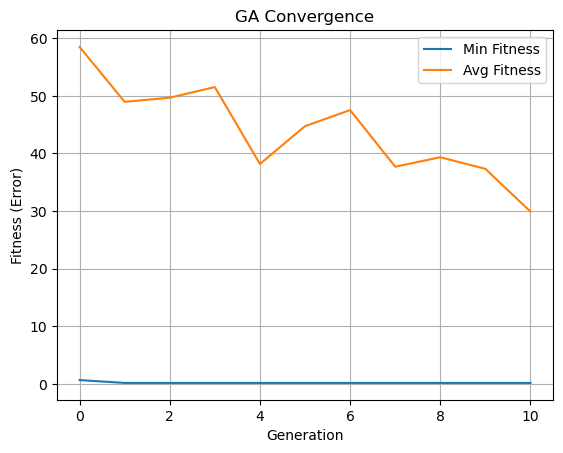

In [18]:
# Logging the statistics
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

# Run the genetic algorithm with logging
population, logbook = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, 
                                          stats=stats, verbose=True)

# Plot the convergence curve
gen = logbook.select("gen")
min_fitness = logbook.select("min")
avg_fitness = logbook.select("avg")

plt.plot(gen, min_fitness, label="Min Fitness")
plt.plot(gen, avg_fitness, label="Avg Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness (Error)")
plt.title("GA Convergence")
plt.legend()
plt.grid()
plt.show()

In [19]:
# Extract the best individual
best_individual = tools.selBest(population, k=1)[0]
best_quantities = np.array(best_individual)
predicted_value = np.sum(best_quantities * nutrient_values)
error = abs(predicted_value - target_value)

#print(f"Best Individual: {best_individual}")
print(f"Predicted Nutrient Value: {predicted_value}")
print(f"Target Nutrient Value: {target_value}")
print(f"Error: {error}")

Predicted Nutrient Value: 14.842276159368396
Target Nutrient Value: 15.0
Error: 0.15772384063160416


In [20]:
def population_diversity(population):
    fitness_values = [ind.fitness.values[0] for ind in population]
    return np.std(fitness_values)

diversity = population_diversity(population)
print(f"Population Diversity: {diversity}")

Population Diversity: 55.72429212449892


In [21]:
num_trials = 10
best_fitnesses = []

for _ in range(num_trials):
    population = toolbox.population(n=100)
    population, _ = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, 
                                        stats=stats, verbose=False)
    best_individual = tools.selBest(population, k=1)[0]
    best_fitnesses.append(best_individual.fitness.values[0])

print(f"Mean Best Fitness over {num_trials} runs: {np.mean(best_fitnesses)}")
print(f"Standard Deviation of Best Fitness: {np.std(best_fitnesses)}")


Mean Best Fitness over 10 runs: 0.2523864464765097
Standard Deviation of Best Fitness: 0.18378748106288523


In [22]:
import time

start_time = time.time()
population, logbook = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, 
                                          stats=stats, verbose=False)
end_time = time.time()

print(f"Execution Time: {end_time - start_time} seconds")


Execution Time: 2.924341917037964 seconds


In [23]:
for cxpb in [0.3, 0.5, 0.7]:
    for mutpb in [0.1, 0.2, 0.3]:
        population = toolbox.population(n=100)
        population, _ = algorithms.eaSimple(population, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=10, 
                                            stats=stats, verbose=False)
        best_individual = tools.selBest(population, k=1)[0]
        print(f"Crossover Probability: {cxpb}, Mutation Probability: {mutpb}, Best Fitness: {best_individual.fitness.values[0]}")


Crossover Probability: 0.3, Mutation Probability: 0.1, Best Fitness: 0.1465111204640266
Crossover Probability: 0.3, Mutation Probability: 0.2, Best Fitness: 0.15366836685814178
Crossover Probability: 0.3, Mutation Probability: 0.3, Best Fitness: 0.5893743435918282
Crossover Probability: 0.5, Mutation Probability: 0.1, Best Fitness: 0.5419444324679716
Crossover Probability: 0.5, Mutation Probability: 0.2, Best Fitness: 1.5154185655072752
Crossover Probability: 0.5, Mutation Probability: 0.3, Best Fitness: 0.12741962274500906
Crossover Probability: 0.7, Mutation Probability: 0.1, Best Fitness: 0.72488114282325
Crossover Probability: 0.7, Mutation Probability: 0.2, Best Fitness: 1.9522419960002253
Crossover Probability: 0.7, Mutation Probability: 0.3, Best Fitness: 0.8223326686729706


In [38]:
#Practical interpretation of the GA
# Sample dataset
data = {
    'Ingredient code': [1001, 19142, 14552, 14555],
    'Ingredient description': ['Butter, salted', 'Candies, MOUNDS Candy Bar', 'Carbonated beverage, chocolate-flavored soda', 'Water, bottled, generic'],
    'Nutrient code': [203, 305, 645, 612],
    'Nutrient value': [0.85, 91, 0, 0]
}

# Extract nutrient values
protein_values = np.array([0.85, 0, 0, 0])  # Protein values (Nutrient Code 203)
sugar_values = np.array([0, 91, 0, 0])      # Sugar values (Nutrient Code 305)

# Parameters
population_size = 10
num_generations = 20
mutation_rate = 0.1

# Fitness function
def fitness_function(chromosome):
    total_protein = np.dot(chromosome, protein_values)
    total_sugar = np.dot(chromosome, sugar_values)
    return total_protein - 0.1 * total_sugar  # Maximize protein, minimize sugar

# Generate initial population
def initialize_population(size):
    return [np.random.randint(2, size=len(protein_values)) for _ in range(size)]

# Selection
def selection(population, fitness_scores):
    # Shift fitness scores to ensure non-negative values
    min_fitness = abs(min(fitness_scores)) if min(fitness_scores) < 0 else 0
    adjusted_fitness_scores = fitness_scores + min_fitness + 1e-6  # Add a small constant to avoid division by zero
    selected = np.random.choice(len(population), size=len(population), p=adjusted_fitness_scores/adjusted_fitness_scores.sum())
    return [population[i] for i in selected]

# Crossover
def crossover(parent1, parent2):
    point = np.random.randint(1, len(parent1)-1)
    return np.concatenate([parent1[:point], parent2[point:]])

# Mutation
def mutate(chromosome):
    for i in range(len(chromosome)):
        if random.random() < mutation_rate:
            chromosome[i] = 1 - chromosome[i]
    return chromosome

# Genetic Algorithm
population = initialize_population(population_size)

for generation in range(num_generations):
    fitness_scores = np.array([fitness_function(chrom) for chrom in population])
    population = selection(population, fitness_scores)
    
    next_population = []
    for i in range(0, len(population), 2):
        parent1, parent2 = population[i], population[i+1]
        child1, child2 = crossover(parent1, parent2), crossover(parent2, parent1)
        next_population.extend([mutate(child1), mutate(child2)])
    
    population = next_population
    
    best_fitness = max(fitness_scores)
    print(f'Generation {generation+1}, Best Fitness: {best_fitness}')

# Results
best_chromosome = population[np.argmax(fitness_scores)]
print("Best Chromosome:", best_chromosome)
print("Best Protein Value:", np.dot(best_chromosome, protein_values))
print("Sugar in Best Diet:", np.dot(best_chromosome, sugar_values))

Generation 1, Best Fitness: 0.85
Generation 2, Best Fitness: 0.85
Generation 3, Best Fitness: 0.85
Generation 4, Best Fitness: 0.85
Generation 5, Best Fitness: 0.85
Generation 6, Best Fitness: 0.85
Generation 7, Best Fitness: 0.85
Generation 8, Best Fitness: 0.85
Generation 9, Best Fitness: 0.85
Generation 10, Best Fitness: 0.85
Generation 11, Best Fitness: 0.85
Generation 12, Best Fitness: 0.85
Generation 13, Best Fitness: 0.85
Generation 14, Best Fitness: 0.85
Generation 15, Best Fitness: 0.85
Generation 16, Best Fitness: 0.85
Generation 17, Best Fitness: 0.85
Generation 18, Best Fitness: 0.85
Generation 19, Best Fitness: 0.85
Generation 20, Best Fitness: 0.85
Best Chromosome: [1 0 0 1]
Best Protein Value: 0.85
Sugar in Best Diet: 0


In [24]:
# Define fuzzy sets manually
def fuzzy_sets(value):
    low = max(0, min(1, (5 - value) / 5))
    medium = max(0, min(1, (value - 0) / 5, (10 - value) / 5))
    high = max(0, min(1, (value - 5) / 5))
    return low, medium, high

# Define rules manually
def fuzzy_rules(low, medium, high):
    if low > medium and low > high:
        return 10  # Low nutrient value
    elif medium > low and medium > high:
        return 15  # Medium nutrient value
    else:
        return 20  # High nutrient value

# Example input: ingredient quantity
ingredient_qty_input = 8  # Example input value
low, medium, high = fuzzy_sets(ingredient_qty_input)
nutrient_value = fuzzy_rules(low, medium, high)
print(f"Recommended nutrient value: {nutrient_value:.2f}")


Recommended nutrient value: 20.00


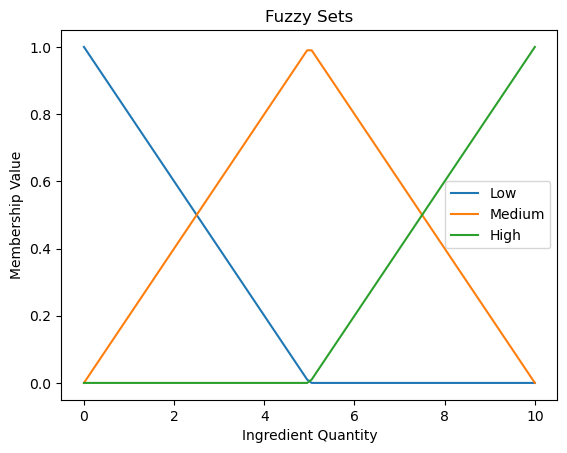

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Range of input values
x = np.linspace(0, 10, 100)
low_values = [fuzzy_sets(val)[0] for val in x]
medium_values = [fuzzy_sets(val)[1] for val in x]
high_values = [fuzzy_sets(val)[2] for val in x]

plt.plot(x, low_values, label='Low')
plt.plot(x, medium_values, label='Medium')
plt.plot(x, high_values, label='High')
plt.xlabel('Ingredient Quantity')
plt.ylabel('Membership Value')
plt.title('Fuzzy Sets')
plt.legend()
plt.show()

In [26]:
test_inputs = [0, 2.5, 5, 7.5, 10]
for val in test_inputs:
    low, medium, high = fuzzy_sets(val)
    nutrient_value = fuzzy_rules(low, medium, high)
    print(f"Input: {val}, Low: {low:.2f}, Medium: {medium:.2f}, High: {high:.2f}, Recommended Nutrient Value: {nutrient_value}")


Input: 0, Low: 1.00, Medium: 0.00, High: 0.00, Recommended Nutrient Value: 10
Input: 2.5, Low: 0.50, Medium: 0.50, High: 0.00, Recommended Nutrient Value: 20
Input: 5, Low: 0.00, Medium: 1.00, High: 0.00, Recommended Nutrient Value: 15
Input: 7.5, Low: 0.00, Medium: 0.50, High: 0.50, Recommended Nutrient Value: 20
Input: 10, Low: 0.00, Medium: 0.00, High: 1.00, Recommended Nutrient Value: 20


In [27]:
test_cases = {
    0: 10,  # Expected low nutrient value
    2.5: 15,  # Expected medium nutrient value
    5: 15,  # Expected medium nutrient value
    7.5: 20,  # Expected high nutrient value
    10: 20  # Expected high nutrient value
}

correct = 0
for input_val, expected_output in test_cases.items():
    low, medium, high = fuzzy_sets(input_val)
    nutrient_value = fuzzy_rules(low, medium, high)
    print(f"Input: {input_val}, Predicted: {nutrient_value}, Expected: {expected_output}")
    if nutrient_value == expected_output:
        correct += 1

accuracy = correct / len(test_cases)
print(f"Accuracy: {accuracy * 100:.2f}%")


Input: 0, Predicted: 10, Expected: 10
Input: 2.5, Predicted: 20, Expected: 15
Input: 5, Predicted: 15, Expected: 15
Input: 7.5, Predicted: 20, Expected: 20
Input: 10, Predicted: 20, Expected: 20
Accuracy: 80.00%


In [28]:
for val in np.arange(2.4, 2.6, 0.01):
    low, medium, high = fuzzy_sets(val)
    nutrient_value = fuzzy_rules(low, medium, high)
    print(f"Input: {val:.2f}, Recommended Nutrient Value: {nutrient_value}")


Input: 2.40, Recommended Nutrient Value: 10
Input: 2.41, Recommended Nutrient Value: 10
Input: 2.42, Recommended Nutrient Value: 10
Input: 2.43, Recommended Nutrient Value: 10
Input: 2.44, Recommended Nutrient Value: 10
Input: 2.45, Recommended Nutrient Value: 10
Input: 2.46, Recommended Nutrient Value: 10
Input: 2.47, Recommended Nutrient Value: 10
Input: 2.48, Recommended Nutrient Value: 10
Input: 2.49, Recommended Nutrient Value: 10
Input: 2.50, Recommended Nutrient Value: 10
Input: 2.51, Recommended Nutrient Value: 15
Input: 2.52, Recommended Nutrient Value: 15
Input: 2.53, Recommended Nutrient Value: 15
Input: 2.54, Recommended Nutrient Value: 15
Input: 2.55, Recommended Nutrient Value: 15
Input: 2.56, Recommended Nutrient Value: 15
Input: 2.57, Recommended Nutrient Value: 15
Input: 2.58, Recommended Nutrient Value: 15
Input: 2.59, Recommended Nutrient Value: 15
Input: 2.60, Recommended Nutrient Value: 15


In [29]:
# Prepare the data for PSO
ingredient_codes = df['ingredient code'].unique()
nutrient_values = df.groupby('ingredient code')['Total Nutrient Value'].mean().values

# Target Nutrient Value (you can set your own target value)
target_nutrient_value = 15.0  # Example value after normalization

# PSO Parameters
num_particles = 100
num_dimensions = len(ingredient_codes)
num_iterations = 100
inertia_weight = 0.5
cognitive_constant = 1.5
social_constant = 2.0

# Initialize particle positions and velocities
particles = np.random.rand(num_particles, num_dimensions)
velocities = np.zeros((num_particles, num_dimensions))

# Personal best positions and global best position
personal_best_positions = particles.copy()
personal_best_scores = np.full(num_particles, float('inf'))
global_best_position = None
global_best_score = float('inf')

# Fitness function: Calculate the difference between the actual and target nutrient values
def fitness_function(particle, nutrient_values, target_value):
    nutrient_combination = np.dot(particle, nutrient_values)
    return np.abs(nutrient_combination - target_value)

# PSO Algorithm
for iteration in range(num_iterations):
    for i in range(num_particles):
        # Calculate fitness score for each particle
        fitness = fitness_function(particles[i], nutrient_values, target_nutrient_value)
        
        # Update personal best
        if fitness < personal_best_scores[i]:
            personal_best_scores[i] = fitness
            personal_best_positions[i] = particles[i]
        
        # Update global best
        if fitness < global_best_score:
            global_best_score = fitness
            global_best_position = particles[i]
    
    # Update velocities and positions
    for i in range(num_particles):
        r1, r2 = np.random.rand(num_dimensions), np.random.rand(num_dimensions)
        cognitive_velocity = cognitive_constant * r1 * (personal_best_positions[i] - particles[i])
        social_velocity = social_constant * r2 * (global_best_position - particles[i])
        velocities[i] = inertia_weight * velocities[i] + cognitive_velocity + social_velocity
        particles[i] += velocities[i]
    
    # Optionally: Print progress
    print(f"Iteration {iteration + 1}/{num_iterations}, Best Fitness: {global_best_score}")

# Results
print("Optimal Ingredient Combination:", global_best_position)
print("Achieved Nutrient Value:", np.dot(global_best_position, nutrient_values))
print("Target Nutrient Value:", target_nutrient_value)

Iteration 1/100, Best Fitness: 4.744097485938283
Iteration 2/100, Best Fitness: 4.744097485938283
Iteration 3/100, Best Fitness: 4.744097485938283
Iteration 4/100, Best Fitness: 4.744097485938283
Iteration 5/100, Best Fitness: 1.4811188730906224
Iteration 6/100, Best Fitness: 0.9698477006499502
Iteration 7/100, Best Fitness: 0.9698477006499502
Iteration 8/100, Best Fitness: 0.9698477006499502
Iteration 9/100, Best Fitness: 0.9698477006499502
Iteration 10/100, Best Fitness: 0.9698477006499502
Iteration 11/100, Best Fitness: 0.8144945222643969
Iteration 12/100, Best Fitness: 0.8144945222643969
Iteration 13/100, Best Fitness: 0.8144945222643969
Iteration 14/100, Best Fitness: 0.8144945222643969
Iteration 15/100, Best Fitness: 0.8144945222643969
Iteration 16/100, Best Fitness: 0.8144945222643969
Iteration 17/100, Best Fitness: 0.5200127766470359
Iteration 18/100, Best Fitness: 0.5200127766470359
Iteration 19/100, Best Fitness: 0.5200127766470359
Iteration 20/100, Best Fitness: 0.5200127766

Iteration 1/100, Best Fitness: 6.696068550207883
Iteration 2/100, Best Fitness: 0.23251506776622932
Iteration 3/100, Best Fitness: 0.23251506776622932
Iteration 4/100, Best Fitness: 0.23251506776622932
Iteration 5/100, Best Fitness: 0.23251506776622932
Iteration 6/100, Best Fitness: 0.23251506776622932
Iteration 7/100, Best Fitness: 0.23251506776622932
Iteration 8/100, Best Fitness: 0.23251506776622932
Iteration 9/100, Best Fitness: 0.23251506776622932
Iteration 10/100, Best Fitness: 0.23251506776622932
Iteration 11/100, Best Fitness: 0.23251506776622932
Iteration 12/100, Best Fitness: 0.23251506776622932
Iteration 13/100, Best Fitness: 0.23251506776622932
Iteration 14/100, Best Fitness: 0.23251506776622932
Iteration 15/100, Best Fitness: 0.23251506776622932
Iteration 16/100, Best Fitness: 0.23251506776622932
Iteration 17/100, Best Fitness: 0.23251506776622932
Iteration 18/100, Best Fitness: 0.14531005494819738
Iteration 19/100, Best Fitness: 0.14531005494819738
Iteration 20/100, Best 

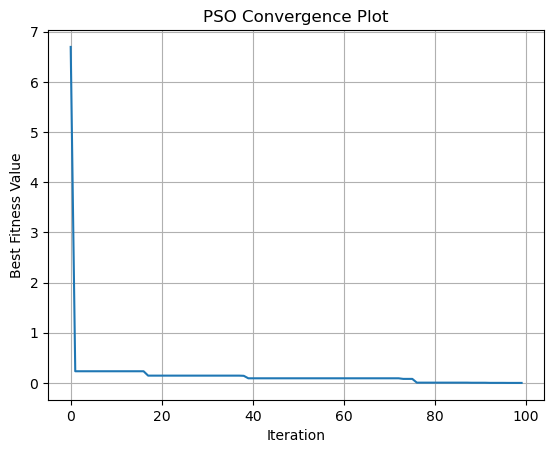

Optimal Ingredient Combination: [ 0.8561613  -0.09665232  0.80356457 ...  0.46651162 -0.12035575
 -0.19260489]
Achieved Nutrient Value: 14.999807315578266
Target Nutrient Value: 15.0


In [30]:
def evaluate_pso_convergence(num_particles, num_dimensions, num_iterations, inertia_weight, cognitive_constant, social_constant, nutrient_values, target_nutrient_value):
    # Initialize variables
    particles = np.random.rand(num_particles, num_dimensions)
    velocities = np.zeros((num_particles, num_dimensions))
    personal_best_positions = particles.copy()
    personal_best_scores = np.full(num_particles, float('inf'))
    global_best_position = None
    global_best_score = float('inf')
    
    # Store best fitness values for plotting
    best_fitness_values = []

    # PSO Algorithm
    for iteration in range(num_iterations):
        for i in range(num_particles):
            # Calculate fitness score for each particle
            fitness = fitness_function(particles[i], nutrient_values, target_nutrient_value)
            
            # Update personal best
            if fitness < personal_best_scores[i]:
                personal_best_scores[i] = fitness
                personal_best_positions[i] = particles[i]
            
            # Update global best
            if fitness < global_best_score:
                global_best_score = fitness
                global_best_position = particles[i]
        
        # Store the best fitness value of this iteration
        best_fitness_values.append(global_best_score)
        
        # Update velocities and positions
        for i in range(num_particles):
            r1, r2 = np.random.rand(num_dimensions), np.random.rand(num_dimensions)
            cognitive_velocity = cognitive_constant * r1 * (personal_best_positions[i] - particles[i])
            social_velocity = social_constant * r2 * (global_best_position - particles[i])
            velocities[i] = inertia_weight * velocities[i] + cognitive_velocity + social_velocity
            particles[i] += velocities[i]

        # Print progress
        print(f"Iteration {iteration + 1}/{num_iterations}, Best Fitness: {global_best_score}")

    return best_fitness_values, global_best_position, np.dot(global_best_position, nutrient_values)

# Run evaluation
best_fitness_values, optimal_position, achieved_value = evaluate_pso_convergence(
    num_particles, num_dimensions, num_iterations, inertia_weight, cognitive_constant, social_constant, nutrient_values, target_nutrient_value)

# Plot convergence
plt.plot(range(num_iterations), best_fitness_values)
plt.xlabel('Iteration')
plt.ylabel('Best Fitness Value')
plt.title('PSO Convergence Plot')
plt.grid(True)
plt.show()

# Results
print("Optimal Ingredient Combination:", optimal_position)
print("Achieved Nutrient Value:", achieved_value)
print("Target Nutrient Value:", target_nutrient_value)


In [31]:
num_trials = 10
all_best_fitnesses = []

for _ in range(num_trials):
    best_fitness_values, _, _ = evaluate_pso_convergence(
        num_particles, num_dimensions, num_iterations, inertia_weight, cognitive_constant, social_constant, nutrient_values, target_nutrient_value)
    all_best_fitnesses.append(best_fitness_values[-1])  # Collect the final best fitness value

mean_best_fitness = np.mean(all_best_fitnesses)
std_best_fitness = np.std(all_best_fitnesses)

print(f"Mean Best Fitness over {num_trials} runs: {mean_best_fitness}")
print(f"Standard Deviation of Best Fitness: {std_best_fitness}")

Iteration 1/100, Best Fitness: 3.2605272839570034
Iteration 2/100, Best Fitness: 1.4986115627460492
Iteration 3/100, Best Fitness: 1.4986115627460492
Iteration 4/100, Best Fitness: 0.6962400363197503
Iteration 5/100, Best Fitness: 0.6962400363197503
Iteration 6/100, Best Fitness: 0.10320231700484328
Iteration 7/100, Best Fitness: 0.10320231700484328
Iteration 8/100, Best Fitness: 0.10320231700484328
Iteration 9/100, Best Fitness: 0.10320231700484328
Iteration 10/100, Best Fitness: 0.10320231700484328
Iteration 11/100, Best Fitness: 0.10320231700484328
Iteration 12/100, Best Fitness: 0.10320231700484328
Iteration 13/100, Best Fitness: 0.10320231700484328
Iteration 14/100, Best Fitness: 0.10320231700484328
Iteration 15/100, Best Fitness: 0.10320231700484328
Iteration 16/100, Best Fitness: 0.10320231700484328
Iteration 17/100, Best Fitness: 0.10320231700484328
Iteration 18/100, Best Fitness: 0.10320231700484328
Iteration 19/100, Best Fitness: 0.10320231700484328
Iteration 20/100, Best Fit

In [32]:
import time

start_time = time.time()
evaluate_pso_convergence(
    num_particles, num_dimensions, num_iterations, inertia_weight, cognitive_constant, social_constant, nutrient_values, target_nutrient_value)
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution Time: {execution_time} seconds")


Iteration 1/100, Best Fitness: 0.9640371158754135
Iteration 2/100, Best Fitness: 0.9640371158754135
Iteration 3/100, Best Fitness: 0.841521923533719
Iteration 4/100, Best Fitness: 0.841521923533719
Iteration 5/100, Best Fitness: 0.841521923533719
Iteration 6/100, Best Fitness: 0.841521923533719
Iteration 7/100, Best Fitness: 0.841521923533719
Iteration 8/100, Best Fitness: 0.07946757959172146
Iteration 9/100, Best Fitness: 0.07946757959172146
Iteration 10/100, Best Fitness: 0.07946757959172146
Iteration 11/100, Best Fitness: 0.07946757959172146
Iteration 12/100, Best Fitness: 0.07946757959172146
Iteration 13/100, Best Fitness: 0.07946757959172146
Iteration 14/100, Best Fitness: 0.07946757959172146
Iteration 15/100, Best Fitness: 0.07946757959172146
Iteration 16/100, Best Fitness: 0.07946757959172146
Iteration 17/100, Best Fitness: 0.07946757959172146
Iteration 18/100, Best Fitness: 0.07946757959172146
Iteration 19/100, Best Fitness: 0.07946757959172146
Iteration 20/100, Best Fitness: 0

In [71]:
#Interpretation of the results with practical example using Genetic Algorithm
# Ingredients data
costs = np.array([4, 6, 5, 7])
cake_ingredients = np.array([15, 20, 25, 30])
target_nutrients = 100

# Define the Genetic Algorithm problem
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.uniform, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=len(costs))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", lambda individual: evaluate(individual, protein_values, costs, target_protein))
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

def evaluate(individual, protein_values, costs, target_protein):
    quantities = np.array(individual)
    total_protein = np.sum(quantities * protein_values)
    total_cost = np.sum(quantities * costs)
    error = abs(total_protein - target_protein)
    return (error + total_cost,)

# Create population and run GA
population = toolbox.population(n=50)
algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, verbose=True)

# Extract the best individual
best_individual = tools.selBest(population, k=1)[0]
best_quantities = np.array(best_individual)
predicted_protein = np.sum(best_quantities * protein_values)
total_cost = np.sum(best_quantities * costs)
error = abs(predicted_protein - target_protein)

print(f"GA - Best Blend Quantities: {best_quantities}")
print(f"GA - Predicted Protein Value: {predicted_protein}")
print(f"GA - Total Cost: {total_cost}")
print(f"GA - Error: {error}")

gen	nevals
0  	50    
1  	33    
2  	36    
3  	35    
4  	30    
5  	29    
6  	19    
7  	22    
8  	20    
9  	29    
10 	31    
GA - Best Blend Quantities: [0.73649177 1.13061314 1.19258753 1.22212782]
GA - Predicted Protein Value: 100.13816221673409
GA - Total Cost: 24.2474783195356
GA - Error: 0.1381622167340879


C:\Users\Naresh Kumar S\.anaconda\.anaconda\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Naresh Kumar S\.anaconda\.anaconda\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [3]:
# Membership functions
def cheese_quantity_low(x):
    return max(0, min(1, (50 - x) / 50))

def cheese_quantity_medium(x):
    if x <= 25:
        return max(0, x / 25)
    elif x <= 75:
        return max(0, (75 - x) / 50)
    return 0

def cheese_quantity_high(x):
    return max(0, (x - 50) / 50)

def protein_level_low(x):
    return max(0, min(1, (10 - x) / 10))

def protein_level_medium(x):
    if x <= 5:
        return max(0, x / 5)
    elif x <= 15:
        return max(0, (15 - x) / 10)
    return 0

def protein_level_high(x):
    return max(0, (x - 10) / 10)

def taste_preference_not_cheesy(x):
    return max(0, min(1, (50 - x) / 50))

def taste_preference_moderate_cheesy(x):
    if x <= 25:
        return max(0, x / 25)
    elif x <= 75:
        return max(0, (75 - x) / 50)
    return 0

def taste_preference_very_cheesy(x):
    return max(0, (x - 50) / 50)

# Fuzzy logic system
def fuzzy_logic_system(cheese_quantity, protein_level, taste_preference):
    # Rule 1: IF cheese_quantity is low AND protein_level is high THEN increase cheese quantity
    rule1 = min(cheese_quantity_low(cheese_quantity), protein_level_high(protein_level))
    
    # Rule 2: IF cheese_quantity is medium AND taste_preference is not_cheesy THEN decrease cheese quantity
    rule2 = min(cheese_quantity_medium(cheese_quantity), taste_preference_not_cheesy(taste_preference))
    
    # Rule 3: IF cheese_quantity is high AND taste_preference is very_cheesy THEN no change in cheese quantity
    rule3 = min(cheese_quantity_high(cheese_quantity), taste_preference_very_cheesy(taste_preference))
    
    # Calculating adjustments
    adjustment_increase = rule1 * 10  # Increase by 10 grams
    adjustment_decrease = rule2 * -10  # Decrease by 10 grams
    no_adjustment = rule3 * 0  # No change
    
    # Defuzzification: Weighted average of adjustments
    numerator = (adjustment_increase + adjustment_decrease + no_adjustment)
    denominator = (rule1 + rule2 + rule3)
    
    if denominator != 0:
        adjustment = numerator / denominator
    else:
        adjustment = 0  # No significant rule activation
    
    optimal_cheese_quantity = cheese_quantity + adjustment
    return optimal_cheese_quantity

# Test the system with various inputs
def test_fuzzy_logic():
    test_cases = [
        {"cheese_quantity": 3, "protein_level": 15, "taste_preference": 80},
        {"cheese_quantity": 60, "protein_level": 5, "taste_preference": 30},
        {"cheese_quantity": 40, "protein_level": 8, "taste_preference": 50},
        {"cheese_quantity": 50, "protein_level": 12, "taste_preference": 70},
    ]
    
    for i, case in enumerate(test_cases):
        cheese_quantity = case["cheese_quantity"]
        protein_level = case["protein_level"]
        taste_preference = case["taste_preference"]
        
        optimal_cheese_quantity = fuzzy_logic_system(cheese_quantity, protein_level, taste_preference)
        print(f"Test {i+1} - Optimal Cheese Quantity: {optimal_cheese_quantity} grams")

# Run the tests
test_fuzzy_logic()


Test 1 - Optimal Cheese Quantity: 13.0 grams
Test 2 - Optimal Cheese Quantity: 50.0 grams
Test 3 - Optimal Cheese Quantity: 40 grams
Test 4 - Optimal Cheese Quantity: 50 grams
